In [1]:
from pathlib import Path
import os
from os.path import join
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages
import re
from gelgenie.segmentation.helper_functions.general_functions import create_dir_if_empty, index_converter
from collections import defaultdict
import pickle
import math
from scipy.stats import linregress
import pingouin
import matplotlib as mpl

In [2]:
# user = 'matthew'
user = 'matthew'
if user == 'matthew':
    base_path = '../../../other_paper_comparisons'
    plt.rcParams.update({'font.sans-serif':'Helvetica'})  # consistent figure formatting
elif user == 'nathan':
    base_path = '../../../paper_data_analysis'
    plt.rcParams.update({'font.sans-serif':'Microsoft Sans Serif'})  # consistent figure formatting

fig2a_df = pd.read_csv(os.path.join(base_path, 'matthew_multiplexed_paper/GelGenie Analysis/fig_2_A_band_data.csv'))
fig2b_df = pd.read_csv(os.path.join(base_path, 'matthew_multiplexed_paper/GelGenie Analysis/fig_2_B_band_data.csv'))
fig2c_df = pd.read_csv(os.path.join(base_path, 'matthew_multiplexed_paper/GelGenie Analysis/fig_2_C_band_data.csv'))
fig2d_df = pd.read_csv(os.path.join(base_path, 'matthew_multiplexed_paper/GelGenie Analysis/fig_2_D_band_data.csv'))
figs1A_df = pd.read_csv(os.path.join(base_path, 'matthew_multiplexed_paper/GelGenie Analysis/fig_s1_A_band_data.csv'))
figs1C_df = pd.read_csv(os.path.join(base_path, 'matthew_multiplexed_paper/GelGenie Analysis/fig_s1_C_band_data.csv'))
figs9A_1_df = pd.read_csv(os.path.join(base_path, 'matthew_multiplexed_paper/GelGenie Analysis/fig_s9_A_band_data.csv'))
figs9A_2_df = pd.read_csv(os.path.join(base_path, 'matthew_multiplexed_paper/GelGenie Analysis/fig_s9_A_band_data_2.csv'))
Modification_required = [False, True, False, True, False, False, False, False]

# minor mods required for no-band areas
arun_2022_fig1f = pd.read_csv(os.path.join(base_path, 'arun_data_2022_toehold_clipping/GelGenie Analysis/fig_1F.csv'))

# # minor mods required for no-band areas
arun_2022_fig3f_1 = pd.read_csv(os.path.join(base_path, 'arun_data_2022_toehold_clipping/GelGenie Analysis/3f_rep_1.csv'))
arun_2022_fig3f_2 = pd.read_csv(os.path.join(base_path, 'arun_data_2022_toehold_clipping/GelGenie Analysis/3f_rep_2.csv'))
arun_2022_fig3f_3 = pd.read_csv(os.path.join(base_path, 'arun_data_2022_toehold_clipping/GelGenie Analysis/3f_rep_3.csv'))

# # finetune model required - minor mods/additions needed for no-band areas
arun_2021_multiplexed_1 = pd.read_csv(os.path.join(base_path, 'arun_data_multiplexed_2021/GelGenie Analysis/fig2c_1.csv'))
arun_2021_multiplexed_2 = pd.read_csv(os.path.join(base_path, 'arun_data_multiplexed_2021/GelGenie Analysis/fig2c_2.csv'))
arun_2021_multiplexed_3 = pd.read_csv(os.path.join(base_path, 'arun_data_multiplexed_2021/GelGenie Analysis/fig2c_3.csv'))

# # finetune model required - minor mods/additions needed for no-band areas
arun_2021_multiplexed_4f_dna = pd.read_csv(os.path.join(base_path, 'arun_data_multiplexed_2021/GelGenie Analysis/fig4f_dna.csv'))
arun_2021_multiplexed_4f_rna = pd.read_csv(os.path.join(base_path, 'arun_data_multiplexed_2021/GelGenie Analysis/fig4f_rna.csv'))
arun_2021_multiplexed_4f_dig = pd.read_csv(os.path.join(base_path, 'arun_data_multiplexed_2021/GelGenie Analysis/fig4f_dig.csv'))
arun_2021_multiplexed_4f_sa = pd.read_csv(os.path.join(base_path, 'arun_data_multiplexed_2021/GelGenie Analysis/fig4f_sa.csv'))

# # finetune model required - minor mods/additions needed for no-band areas
arun_2021_multiplexed_S4 = pd.read_csv(os.path.join(base_path, 'arun_data_multiplexed_2021/GelGenie Analysis/figS4.csv'))
arun_2021_multiplexed_S4_auto = pd.read_csv(os.path.join(base_path, 'arun_data_multiplexed_2021/GelGenie Analysis/figS4_auto.csv'))

# # finetune model required - minor mods/additions needed for no-band areas
arun_2021_multiplexed_S5_1 = pd.read_csv(os.path.join(base_path, 'arun_data_multiplexed_2021/GelGenie Analysis/figS5_1.csv'))
arun_2021_multiplexed_S5_2 = pd.read_csv(os.path.join(base_path, 'arun_data_multiplexed_2021/GelGenie Analysis/figS5_2.csv'))
arun_2021_multiplexed_S5_3 = pd.read_csv(os.path.join(base_path, 'arun_data_multiplexed_2021/GelGenie Analysis/figS5_3.csv'))

### Combined Analysis of Multiplexing Paper

In [3]:
col_list = []
gel_names = ['2A', '2B', '2C','2D', 'S1A', 'S1C', 'S9A-1', 'S9A-2']
lod_vals = [[False, True, True, False, True, False, True, False, False, True, True],
           [False, True, False, True, False, True, False, False, True, True, True],
            [False]*5,
           [False, True, True, False, True, False, True, False, False, True, True],
           [False]*11,
            [False]*11,
            [False, False, True, True, True, True, True, True],
            [False, False, True, True, True, True, True, True]
           ]

def normalize_by_min_max(x):
    return (x -x.min())/ (x.max()-x.min())
    
def normalize_by_max(x):
    return x / x.max()

for df, name, lod_vals in zip([fig2a_df, fig2b_df, fig2c_df, fig2d_df, figs1A_df, figs1C_df, figs9A_1_df, figs9A_2_df],  gel_names, lod_vals):
    df['Gel Name'] = name
    df['LOD Values'] = lod_vals
    if 'Reference' not in (df.columns):
        df['Reference'] = range(1, len(df)+1)
    col_list.append(df[['Gel Name', 'Reference', 'Previous Analysis', 'Rolling Ball Corrected Volume', 'LOD Values']])

ma_multi_df = pd.concat(col_list)
sel_transform = normalize_by_min_max
ma_multi_df['Norm. Prev. Analysis'] = ma_multi_df.groupby('Gel Name')['Previous Analysis'].transform(sel_transform)
ma_multi_df['Norm. GelGenie'] = ma_multi_df.groupby('Gel Name')['Rolling Ball Corrected Volume'].transform(sel_transform)
ma_multi_df['ABS Error'] = abs(ma_multi_df['Norm. Prev. Analysis'] - ma_multi_df['Norm. GelGenie'])

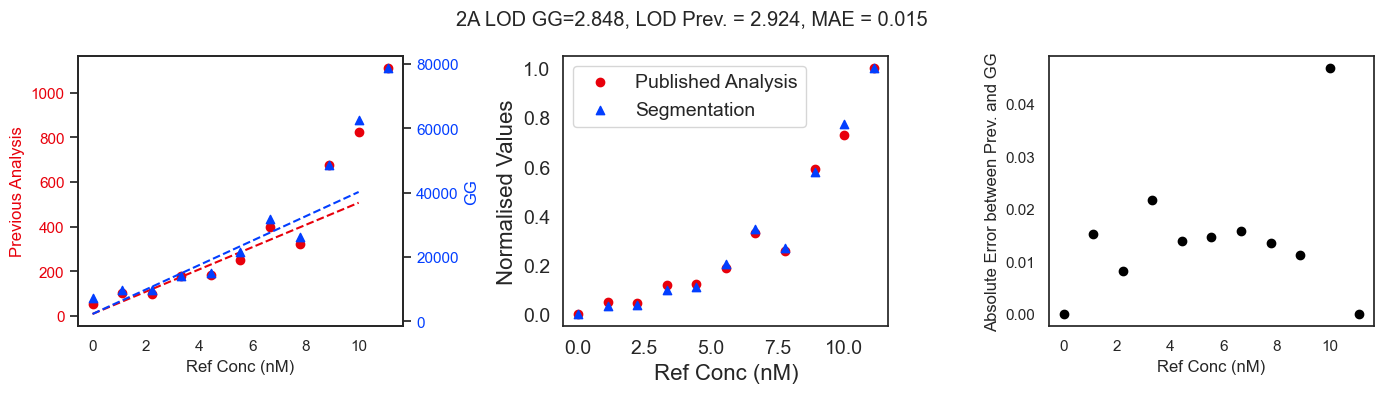

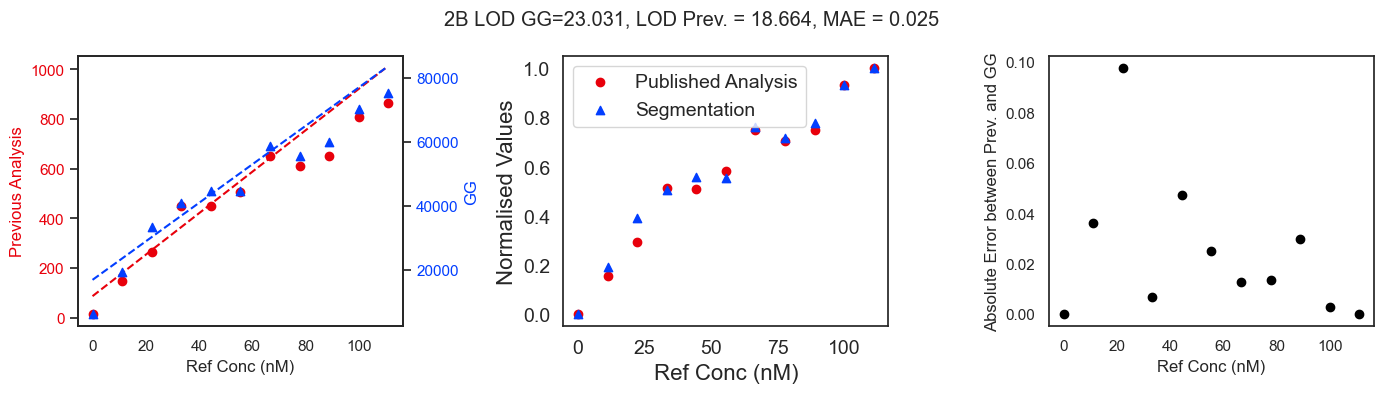

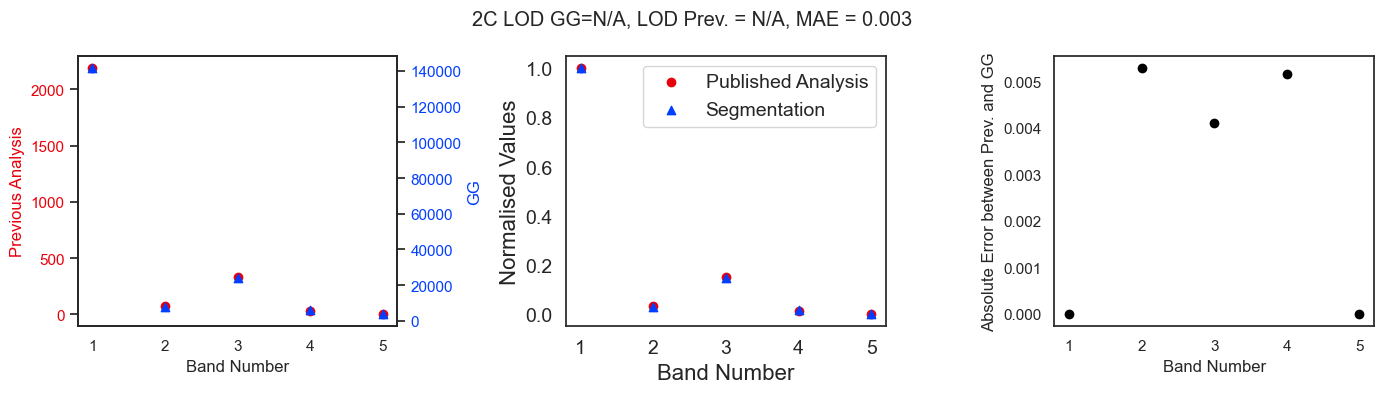

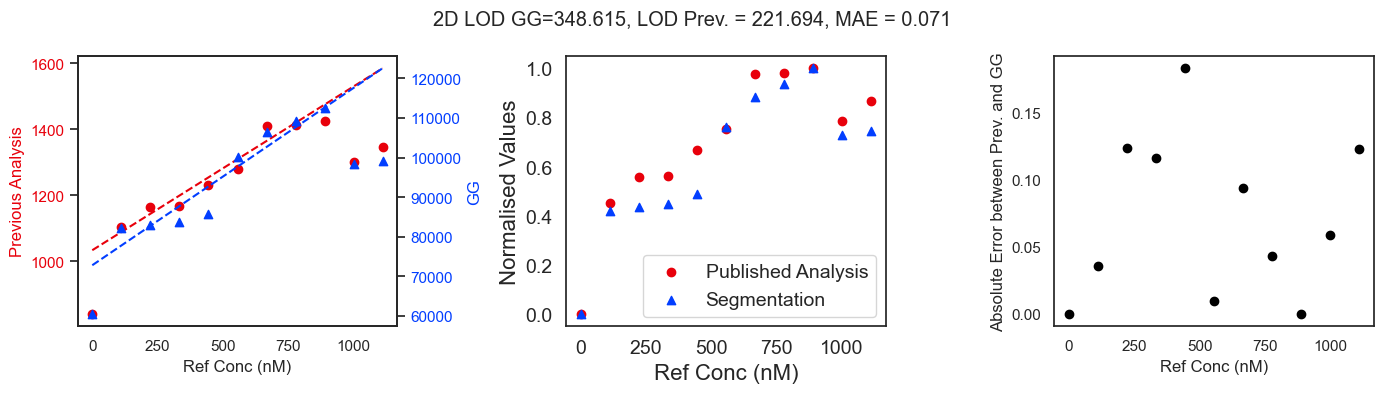

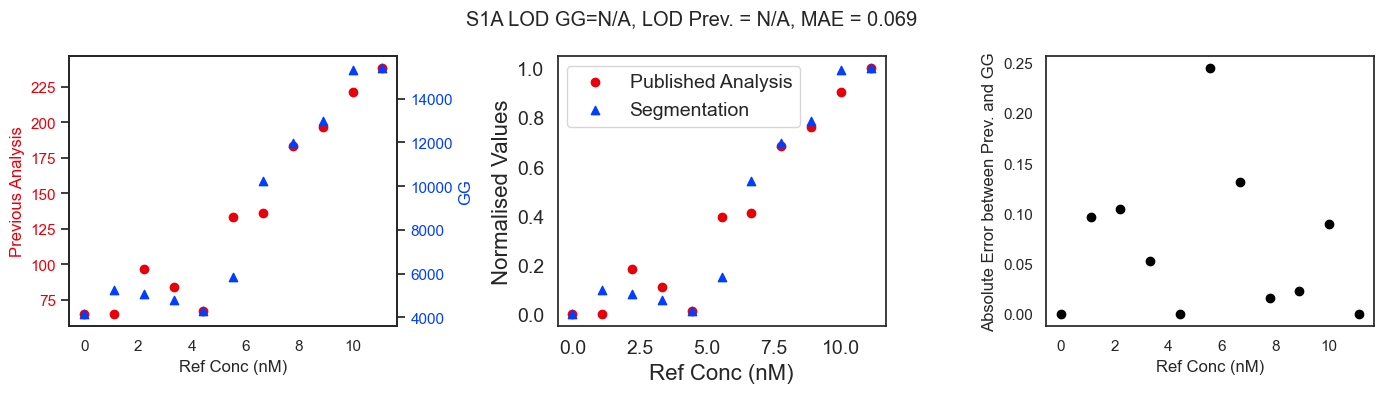

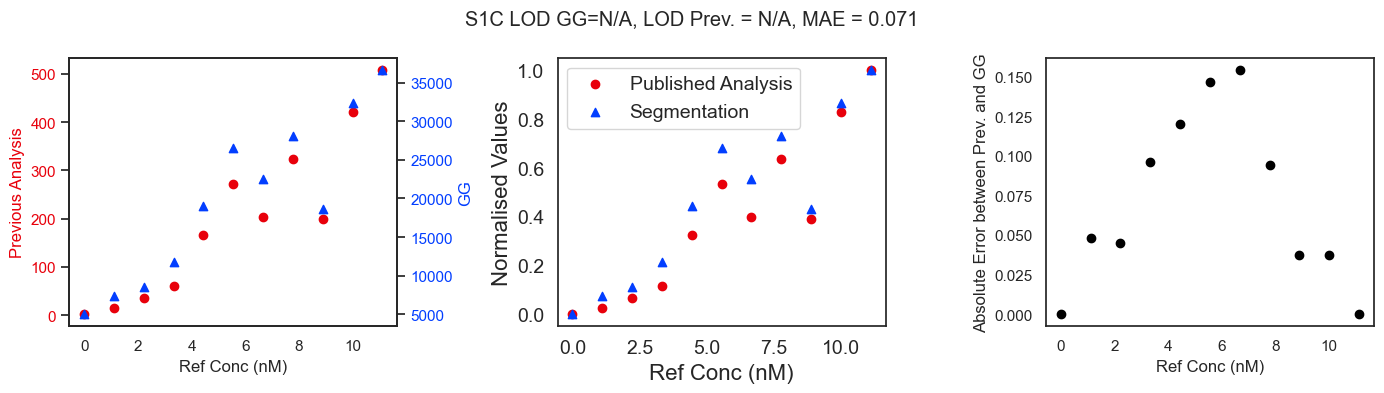

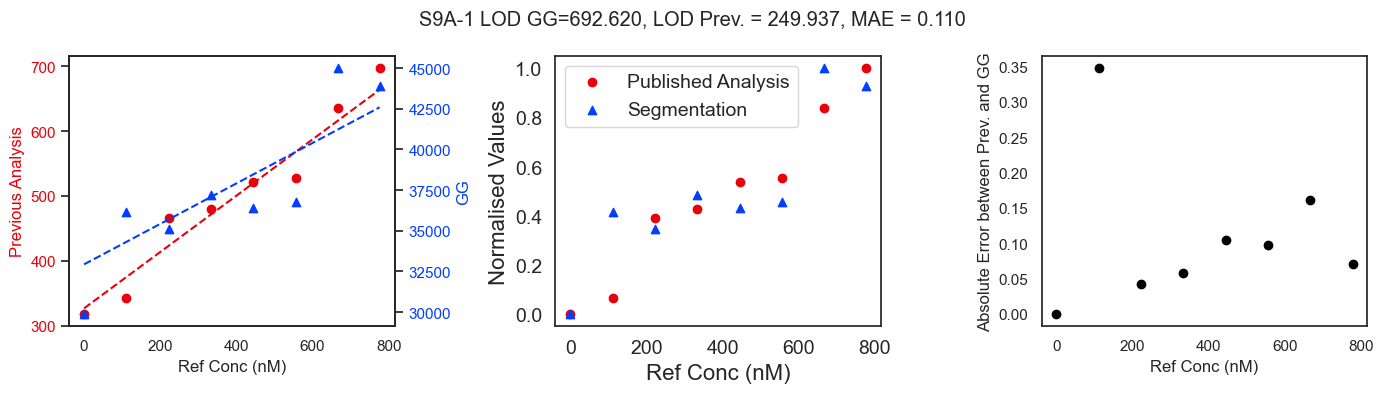

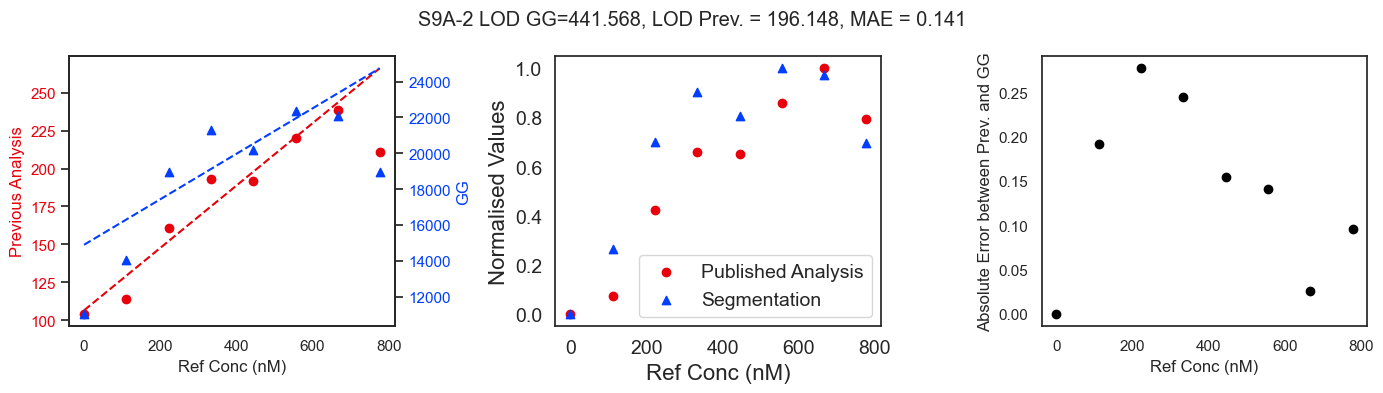

In [9]:
gg_color = '#023eff'
prev_color = '#e8000b'
error_color = 'black'
label_fontsize = 16
tick_fontsize = 14
sns.set(style="white")

for gel in gel_names:
    df_filt = ma_multi_df[ma_multi_df['Gel Name'] == gel]
    ngg_data = df_filt['Norm. GelGenie']
    np_data = df_filt['Norm. Prev. Analysis']
    gg_data = df_filt['Rolling Ball Corrected Volume']
    p_data = df_filt['Previous Analysis']
    ref_data = df_filt['Reference']

    AE = abs(ngg_data - np_data)
    MAE = np.mean(AE)
    
    if sum(df_filt['LOD Values']) > 0:
        lod_filt = df_filt[df_filt['LOD Values']]
        fit_result_p = linregress(lod_filt['Reference'], lod_filt['Previous Analysis'])
        fit_result_gg = linregress(lod_filt['Reference'], lod_filt['Rolling Ball Corrected Volume'])

        lod_p = 3.3*(fit_result_p.intercept_stderr/fit_result_p.slope)
        lod_gg = 3.3*(fit_result_gg.intercept_stderr/fit_result_gg.slope)
    else:
        lod_p = 'N/A'
        lod_gg = 'N/A'
        
    fig, axs = plt.subplots(1,3, figsize=(14,4))
    ax1 = axs[0]
    ax2 = axs[1]
    ax3 = axs[2]

    ax1.scatter(ref_data, p_data, c=prev_color)
    ax1.tick_params(axis='y', labelcolor=prev_color)
    ax1.set_xlabel('Ref Conc (nM)')
    ax1.set_ylabel('Previous Analysis', color=prev_color)
    ax1_1 = ax1.twinx() 
    ax1_1.set_ylabel('GG', color=gg_color)  
    ax1_1.scatter(ref_data, gg_data, c=gg_color, marker='^')
    ax1_1.tick_params(axis='y', labelcolor=gg_color)

    if sum(df_filt['LOD Values']) > 0:
        x_vals = range(0, int(max(ref_data)))
        ax1.plot(x_vals, fit_result_p.slope*x_vals + fit_result_p.intercept, c=prev_color, linestyle='dashed')
        ax1_1.plot(x_vals, fit_result_gg.slope*x_vals + fit_result_gg.intercept, c=gg_color, linestyle='dashed')

    ax2.scatter(ref_data, np_data, c=prev_color, label='Published Analysis')
    ax2.scatter(ref_data, ngg_data, c=gg_color, marker='^', label='Segmentation')
    ax2.set_xlabel('Ref Conc (nM)', fontsize=label_fontsize)
    ax2.set_ylabel('Normalised Values', fontsize=label_fontsize)
    ax2.tick_params(axis='x', labelsize=tick_fontsize)
    ax2.tick_params(axis='y', labelsize=tick_fontsize)

    ax2.legend(fontsize=tick_fontsize)
    
    ax3.scatter(ref_data, AE, c=error_color)
    ax3.set_xlabel('Ref Conc (nM)')
    ax3.set_ylabel('Absolute Error between Prev. and GG')

    if gel == '2C':
        ax1.set_xlabel('Band Number')
        ax2.set_xlabel('Band Number')
        ax3.set_xlabel('Band Number')

    if isinstance(lod_gg, str):
        plt.suptitle(gel + ' LOD GG=%s, LOD Prev. = %s, MAE = %.3f' % (lod_gg, lod_p, MAE))
    else:
        plt.suptitle(gel + ' LOD GG=%.3f, LOD Prev. = %.3f, MAE = %.3f' % (lod_gg, lod_p, MAE))

    fig.tight_layout()  # otherwise the right y-label is slightly clipped

    # when exporting figures, use the following command:
    plt.savefig('/Users/matt/Desktop/multiplexed_paper_gel_%s_analysis.pdf' % gel, dpi=300)
    source_data_export_df = df_filt[['Reference', 'Norm. Prev. Analysis', 'Norm. GelGenie']].copy()
    source_data_export_df.to_excel(f'/Users/matt/Desktop/{gel}_scatter_plot_source_data.xlsx', index=False)

/var/folders/bf/svk708557cgcqbh0gyt7f3gw0000gn/T/ipykernel_19887/546146502.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(data=ma_multi_df, x='Gel Name', y='ABS Error', showfliers=False, linewidth=2.5, palette=palette)
/var/folders/bf/svk708557cgcqbh0gyt7f3gw0000gn/T/ipykernel_19887/546146502.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(data=ma_multi_df, x='Gel Name', y='ABS Error',


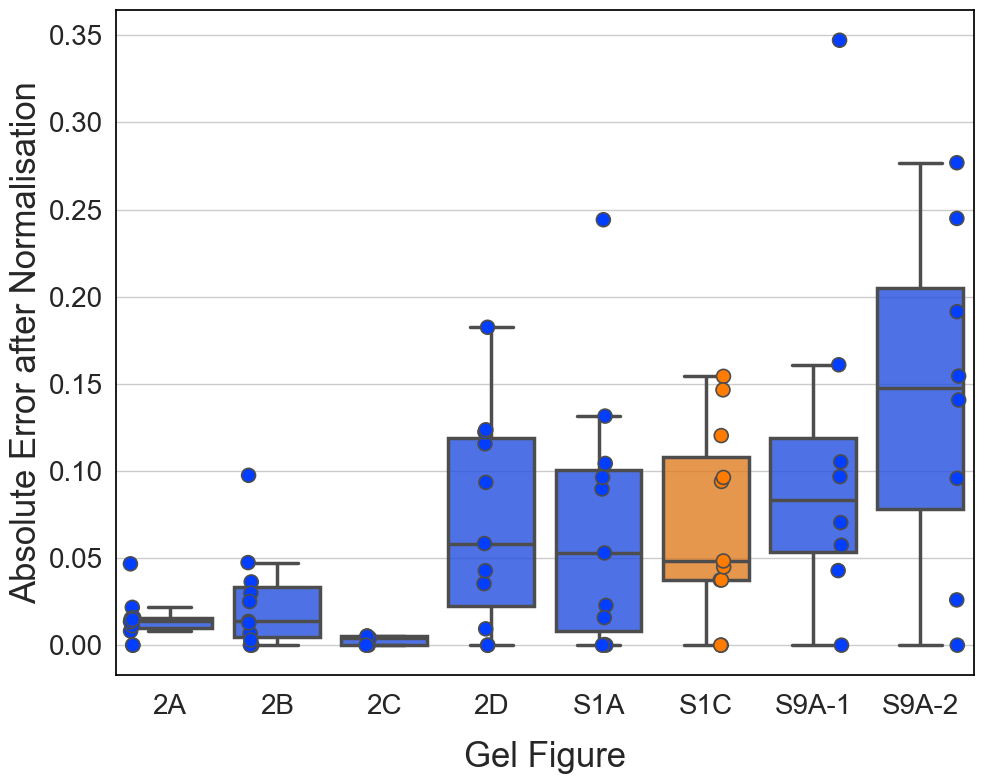

In [8]:
# quick barcharts for each gel

# my interpretation:
# gels 1-3 were clean, clear gels with very distinct bands
# gels 4-6 were so-so - a clear trend was visible in the gel but bands were more diffuse and certain bands in the middle of the distribution introduce more uncertainty
# gels 7-8 are the worst of the dataset - the bands are very similar in intensity and large errors in certain bands skewed the error significantly
plt.figure(figsize=(10,8))
sel_color = '#023eff'
sel_color_2 = '#001c7f'
palette = [sel_color]*5 + ['#ff7c00'] + [sel_color]*2


sns.set(style="whitegrid")
ax = sns.boxplot(data=ma_multi_df, x='Gel Name', y='ABS Error', showfliers=False, linewidth=2.5, palette=palette)
sns.stripplot(data=ma_multi_df, x='Gel Name', y='ABS Error', 
              jitter=0.15, legend=False, dodge=True, s=10,
              alpha=1.0, marker="o", palette = palette,
              linewidth=1.2)

ax.tick_params(axis='x', labelsize=20, size=10)

for patch in ax.patches:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, 0.8))

ax.spines['top'].set_color('black')
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')
ax.spines['right'].set_color('black')

plt.xlabel('Gel Figure', fontsize=25, labelpad=15)
plt.ylabel('Absolute Error after Normalisation', fontsize=25)
plt.yticks(fontsize=20)
# plt.ylim([0,60])
plt.tight_layout()
plt.savefig('/Users/matt/Desktop/multiplexed_paper_boxplots.pdf', dpi=300)

# export for source data file
source_data_export_df = ma_multi_df[['Gel Name', 'ABS Error']].copy()

source_data_export_df.to_excel('/Users/matt/Desktop/figure_4a_box_plot_source_data.xlsx', index=False)

In [34]:
pl = 'bright'
print(sns.color_palette(pl).as_hex())
sns.color_palette(pl)

['#023eff', '#ff7c00', '#1ac938', '#e8000b', '#8b2be2', '#9f4800', '#f14cc1', '#a3a3a3', '#ffc400', '#00d7ff']


[(0.00784313725490196, 0.24313725490196078, 1.0),
 (1.0, 0.48627450980392156, 0.0),
 (0.10196078431372549, 0.788235294117647, 0.2196078431372549),
 (0.9098039215686274, 0.0, 0.043137254901960784),
 (0.5450980392156862, 0.16862745098039217, 0.8862745098039215),
 (0.6235294117647059, 0.2823529411764706, 0.0),
 (0.9450980392156862, 0.2980392156862745, 0.7568627450980392),
 (0.6392156862745098, 0.6392156862745098, 0.6392156862745098),
 (1.0, 0.7686274509803922, 0.0),
 (0.0, 0.8431372549019608, 1.0)]

In [39]:
pl = 'dark'
print(sns.color_palette(pl).as_hex())
sns.color_palette(pl)

['#001c7f', '#b1400d', '#12711c', '#8c0800', '#591e71', '#592f0d', '#a23582', '#3c3c3c', '#b8850a', '#006374']


[(0.0, 0.10980392156862745, 0.4980392156862745),
 (0.6941176470588235, 0.25098039215686274, 0.050980392156862744),
 (0.07058823529411765, 0.44313725490196076, 0.10980392156862745),
 (0.5490196078431373, 0.03137254901960784, 0.0),
 (0.34901960784313724, 0.11764705882352941, 0.44313725490196076),
 (0.34901960784313724, 0.1843137254901961, 0.050980392156862744),
 (0.6352941176470588, 0.20784313725490197, 0.5098039215686274),
 (0.23529411764705882, 0.23529411764705882, 0.23529411764705882),
 (0.7215686274509804, 0.5215686274509804, 0.0392156862745098),
 (0.0, 0.38823529411764707, 0.4549019607843137)]

## Arun 2022 Toehold Clipping

In [21]:
arun_2022_fig1f

,Lane ID,Band ID,Raw Volume,Rolling Ball Corrected Volume,Original Analysis,Reference
0,1,1,2353841,1885361,12330.338,0
1,2,1,1972086,1556269,10372.095,2
2,3,1,903136,501177,3997.246,4
3,4,1,599495,281472,2344.276,8
4,5,1,446819,89854,815.092,16
5,6,1,436956,74835,475.607,32
6,7,1,421047,55031,476.192,64


/var/folders/bf/svk708557cgcqbh0gyt7f3gw0000gn/T/ipykernel_19887/1989527524.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(arun_2022_fig1f['Reference'], fontsize=tick_fontsize)


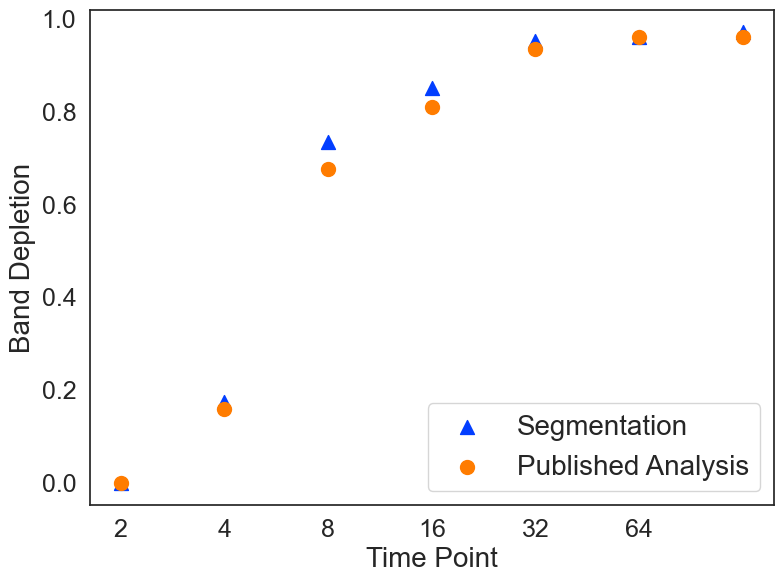

In [11]:
gg_color = '#023eff'
prev_color = '#ff7c00'

label_fontsize = 20
tick_fontsize = 18

fig, ax = plt.subplots(figsize=(8, 6))

orig_data = np.array(arun_2022_fig1f['Original Analysis'])
gg_data = np.array(arun_2022_fig1f['Raw Volume'])
gg_data_bc = np.array(arun_2022_fig1f['Rolling Ball Corrected Volume'])

# normalisation identical to that computed in the paper
orig_data = (orig_data[0] - orig_data)/orig_data[0]
gg_data = (gg_data[0] - gg_data)/gg_data[0]
gg_data_bc = (gg_data_bc[0] - gg_data_bc)/gg_data_bc[0]

plt.scatter(range(len(gg_data_bc)), gg_data_bc, label='Segmentation', c=gg_color, marker='^', s=100) 
plt.scatter(range(len(gg_data_bc)), orig_data, label='Published Analysis', color=prev_color, s=100) # used different colour to show it was from a different paper

plt.legend(fontsize=label_fontsize)
plt.xlabel('Time Point', fontsize=label_fontsize)
plt.ylabel('Band Depletion', fontsize=label_fontsize)
ax.tick_params(axis='y', labelsize=tick_fontsize)
ax.set_xticklabels(arun_2022_fig1f['Reference'], fontsize=tick_fontsize)
plt.tight_layout()
plt.savefig('/Users/matt/Desktop/arun_2022_fig1f_analysis.pdf', dpi=300)

source_data_export_df = arun_2022_fig1f[['Reference', 'Original Analysis', 'Rolling Ball Corrected Volume']].copy()
source_data_export_df.rename(columns = {'Reference': 'Time Point', 'Original Analysis': 'Published Analysis', 'Rolling Ball Corrected Volume': 'Segmentation'}, inplace=True)
source_data_export_df.to_excel('/Users/matt/Desktop/figure_4b_scatter_plot_source_data.xlsx', index=False)

In [107]:
full_data_df.groupby(['Analysis', 'Type'])['Value'].mean().reset_index()

,Analysis,Type,Value
0,Published Analysis,DNA,93.331958
1,Published Analysis,RNA,90.426695
2,Published Analysis,RNASE,17.253572
3,Segmentation Analysis,DNA,94.292225
4,Segmentation Analysis,RNA,87.794216
5,Segmentation Analysis,RNASE,15.646881


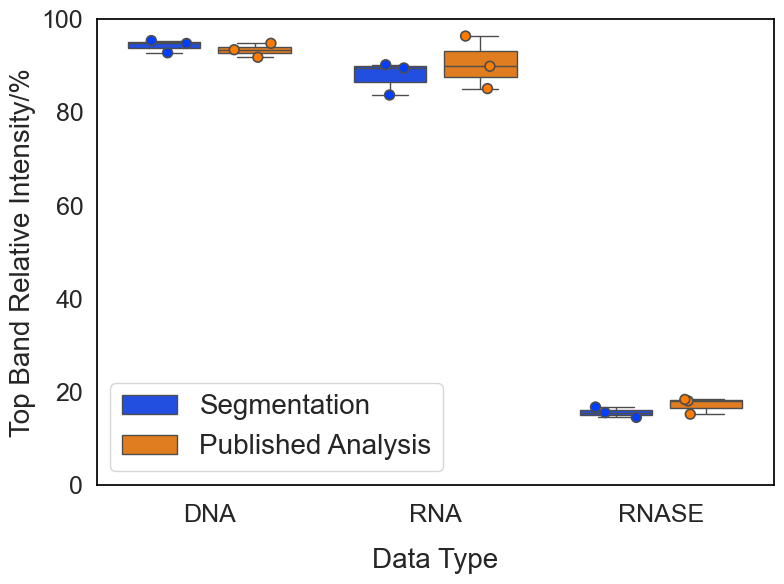

In [12]:
fig, ax1 = plt.subplots(figsize=(8,6))

full_data = defaultdict(list)

for d in [arun_2022_fig3f_1, arun_2022_fig3f_2, arun_2022_fig3f_3]:

    full_data['Value'].append((100*d['Rolling Ball Corrected Volume'][0])/(d['Rolling Ball Corrected Volume'][0]+d['Rolling Ball Corrected Volume'][1]))
    full_data['Analysis'].append("Segmentation")
    full_data['Type'].append('DNA')

    full_data['Value'].append((100*d['Rolling Ball Corrected Volume'][2])/(d['Rolling Ball Corrected Volume'][2]+d['Rolling Ball Corrected Volume'][3]))
    full_data['Analysis'].append("Segmentation")
    full_data['Type'].append('RNA')

    full_data['Value'].append((100*d['Rolling Ball Corrected Volume'][4])/(d['Rolling Ball Corrected Volume'][4]+d['Rolling Ball Corrected Volume'][5]))
    full_data['Analysis'].append("Segmentation")
    full_data['Type'].append('RNASE')

    full_data['Value'].append((100*d['Provided Analysis'][0])/(d['Provided Analysis'][0]+d['Provided Analysis'][1]))
    full_data['Analysis'].append("Published Analysis")
    full_data['Type'].append('DNA')

    full_data['Value'].append((100*d['Provided Analysis'][2])/(d['Provided Analysis'][2]+d['Provided Analysis'][3]))
    full_data['Analysis'].append("Published Analysis")
    full_data['Type'].append('RNA')

    full_data['Value'].append((100*d['Provided Analysis'][4])/(d['Provided Analysis'][4]+d['Provided Analysis'][5]))
    full_data['Analysis'].append("Published Analysis")
    full_data['Type'].append('RNASE')

full_data_df = pd.DataFrame.from_dict(full_data)

ax = sns.boxplot(data=full_data_df, x='Type', y='Value', hue='Analysis', palette = ['#023eff', '#ff7c00'], gap=.2,
                 showfliers=False)
stripplot = sns.stripplot(data=full_data_df, x='Type', y='Value',hue='Analysis', palette = ['#023eff', '#ff7c00'],
              jitter=0.2, legend=False, dodge=True, s=7,
              alpha=1.0, marker="o", 
              linewidth=1.2)

ax.tick_params(axis='x', labelsize=18, size=10)

ax.spines['top'].set_color('black')
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')
ax.spines['right'].set_color('black')

plt.xlabel('Data Type', fontsize=20, labelpad=15)
plt.ylabel('Top Band Relative Intensity/%', fontsize=20)
plt.yticks(fontsize=18)
plt.ylim([0,100])
plt.legend(title=None, fontsize=20)

plt.tight_layout()

plt.savefig('/Users/matt/Desktop/arun_2022_fig3f_analysis.pdf', dpi=300)
full_data_df.to_excel('/Users/matt/Desktop/figure_4b_box_plot_source_data.xlsx', index=False)

## Arun Multiplexed 2021

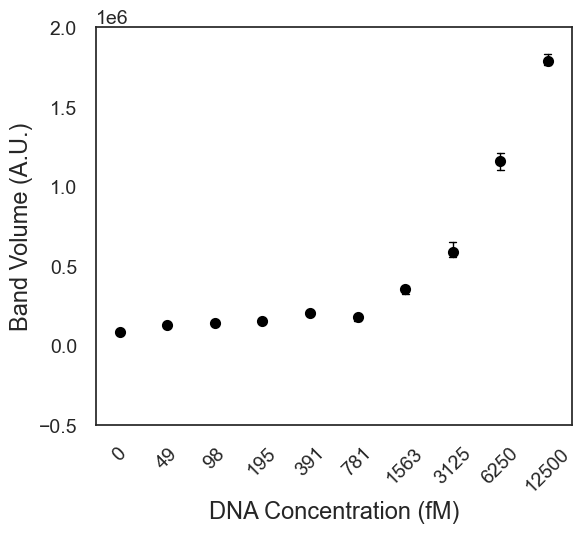

In [20]:
# fig 2c
fig, ax = plt.subplots(figsize=(6,5.5))
from matplotlib.ticker import ScalarFormatter

scat_size = 6
label_size = 17
axis_size = 14


full_arun_multiplexed_df = pd.concat([arun_2021_multiplexed_1, arun_2021_multiplexed_2, arun_2021_multiplexed_3], ignore_index=True)
p_plot = sns.pointplot(data=full_arun_multiplexed_df, x='Reference', y='Rolling Ball Corrected Volume',
              linestyle='none', capsize=0.15, err_kws={'linewidth': 1}, color='black')

for line in p_plot.lines:
    line.set_markersize(scat_size)  

ax.set_ylabel('Band Volume (A.U.)', fontsize=label_size)
ax.set_xlabel('DNA Concentration (fM)', fontsize=label_size)
ax.tick_params(axis='x', labelsize=axis_size, size=10, rotation=45)
ax.tick_params(axis='y', labelsize=axis_size, size=10)

formatter = ScalarFormatter()
formatter.set_powerlimits((-3, 3))  
ax.yaxis.set_major_formatter(formatter)
ax.yaxis.get_offset_text().set_size(axis_size) 
plt.ylim([-500000, 2000000])

plt.tight_layout()
plt.savefig('/Users/matt/Desktop/arun_2021_fig2c_analysis.pdf', dpi=300)
source_data_export_df = full_arun_multiplexed_df[['Reference', 'Rolling Ball Corrected Volume']].copy()
source_data_export_df.rename(columns={'Reference': 'DNA Concentration (fM)', 'Rolling Ball Corrected Volume': 'Band Volume (arb. units)'}).to_excel(f'/Users/matt/Desktop/figure_4c_left_scatter_plot_source_data.xlsx', index=False)


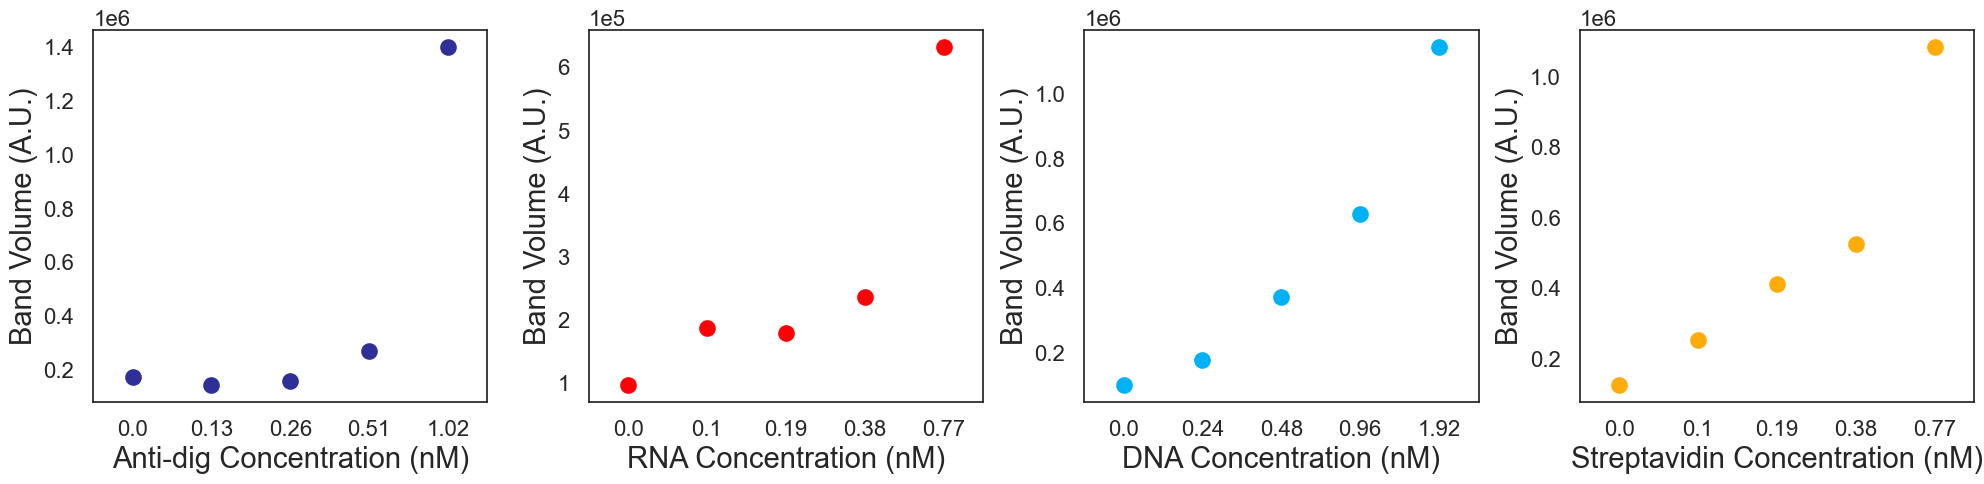

In [18]:
# fig 4f

from matplotlib.ticker import ScalarFormatter

fig, axs = plt.subplots(1, 4, figsize=(20,5))

ax1 = axs[0]
ax2 = axs[1]
ax3 = axs[2]
ax4 = axs[3]

scat_size = 12
label_size = 21
axis_size = 16

sns.stripplot(x='Reference', y='Rolling Ball Corrected Volume', data=arun_2021_multiplexed_4f_dig, ax=ax1, s=scat_size, c='#2E3098')
sns.stripplot(x='Reference', y='Rolling Ball Corrected Volume', data=arun_2021_multiplexed_4f_rna, ax=ax2, s=scat_size, c='#FF0006')
sns.stripplot(x='Reference', y='Rolling Ball Corrected Volume', data=arun_2021_multiplexed_4f_dna, ax=ax3, s=scat_size, c='#00B1F5')
sns.stripplot(x='Reference', y='Rolling Ball Corrected Volume', data=arun_2021_multiplexed_4f_sa, ax=ax4, s=scat_size, c='#FFAC0A')

ax1.set_ylabel('Band Volume (A.U.)', fontsize=label_size)
ax2.set_ylabel('Band Volume (A.U.)', fontsize=label_size)
ax3.set_ylabel('Band Volume (A.U.)', fontsize=label_size)
ax4.set_ylabel('Band Volume (A.U.)', fontsize=label_size)

ax1.set_xlabel('Anti-dig Concentration (nM)', fontsize=label_size)
ax2.set_xlabel('RNA Concentration (nM)', fontsize=label_size)
ax3.set_xlabel('DNA Concentration (nM)', fontsize=label_size)
ax4.set_xlabel('Streptavidin Concentration (nM)', fontsize=label_size)

ax1.tick_params(axis='x', labelsize=axis_size, size=10)
ax2.tick_params(axis='x', labelsize=axis_size, size=10)
ax3.tick_params(axis='x', labelsize=axis_size, size=10)
ax4.tick_params(axis='x', labelsize=axis_size, size=10)

ax1.tick_params(axis='y', labelsize=axis_size, size=10)
ax2.tick_params(axis='y', labelsize=axis_size, size=10)
ax3.tick_params(axis='y', labelsize=axis_size, size=10)
ax4.tick_params(axis='y', labelsize=axis_size, size=10)

formatter = ScalarFormatter()
formatter.set_powerlimits((-3, 3))  

ax1.yaxis.set_major_formatter(formatter)
ax2.yaxis.set_major_formatter(formatter)
ax3.yaxis.set_major_formatter(formatter)
ax4.yaxis.set_major_formatter(formatter)

ax1.yaxis.get_offset_text().set_size(axis_size) 
ax2.yaxis.get_offset_text().set_size(axis_size) 
ax3.yaxis.get_offset_text().set_size(axis_size) 
ax4.yaxis.get_offset_text().set_size(axis_size) 

plt.tight_layout()

plt.savefig('/Users/matt/Desktop/arun_2021_fig4f_analysis.pdf', dpi=300)

for data, name in zip([arun_2021_multiplexed_4f_dig, arun_2021_multiplexed_4f_rna, arun_2021_multiplexed_4f_dna, arun_2021_multiplexed_4f_sa], ['dig', 'rna', 'dna', 'sa']):
    source_data_export_df = data[['Reference', 'Rolling Ball Corrected Volume']].copy()
    source_data_export_df.rename(columns = {'Reference': 'Concentration (nM)', 'Rolling Ball Corrected Volume': 'Band Volume (arb. units)'}, inplace=True)
    source_data_export_df.to_excel(f'/Users/matt/Desktop/figure_4c_{name}_scatter_plot_source_data.xlsx', index=False)


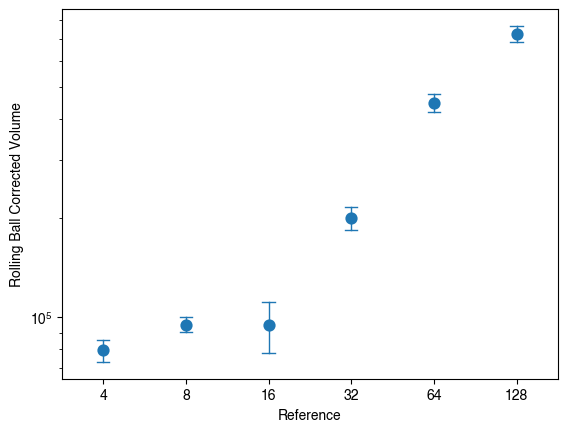

In [22]:
S5 = [arun_2021_multiplexed_S5_1, arun_2021_multiplexed_S5_2, arun_2021_multiplexed_S5_3]

full_df = pd.concat(S5)

sns.pointplot(data=full_df, x='Reference', y='Rolling Ball Corrected Volume', 
              errorbar='sd', err_kws={'linewidth': 1},
              linestyle='none', capsize=0.15, color='tab:blue')  
plt.yscale('log')